In [5]:
from pathlib import Path
import json
import pandas as pd

def _safe_float(x):
    try:
        return float(x)
    except (TypeError, ValueError):
        return None

def load_results(query_list, path_template):
    rows = []
    for q in query_list:
        p = Path(path_template.format(query=q))
        if not p.exists():
            print(f"[WARN] Missing file for {q}: {p}")
            continue
        with p.open('r') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                try:
                    obj = json.loads(line)
                except json.JSONDecodeError as e:
                    print(f"[WARN] JSON error in {p}: {e}")
                    continue
                rows.append({
                    "query": q,
                    "iteration": obj.get("iteration"),
                    "selected_queries": obj.get("selected_queries"),
                    "mean_acc": obj.get("mean_acc"),
                    "mean_ppl": _safe_float(obj.get("mean_ppl")),
                })
    df = pd.DataFrame(rows)
    print(len(rows))
    # Normalize selected_queries and types
    if not df.empty:
        df["selected_queries"] = df["selected_queries"].apply(lambda s: None if s in (None, "None", "", "null") else str(s))
        df["iteration"] = pd.to_numeric(df["iteration"], errors="coerce").astype("Int64")
        df["mean_acc"] = pd.to_numeric(df["mean_acc"], errors="coerce")
    return df.sort_values(["query", "iteration"])


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_per_iter_seaborn(per_iter_dict, metric="mean_acc", title=None, rolling=None, markers=False):
    """
    Plot multiple per-iteration curves (e.g., mean_acc or mean_ppl) using seaborn.
    
    Args:
        per_iter_dict: dict[str, pd.DataFrame]
            Mapping label -> DataFrame with columns ['iteration', metric].
        metric: str
            Column to plot, e.g., 'mean_acc' or 'mean_ppl'.
        title: str | None
            Optional title.
        rolling: int | None
            If set (e.g., 3), applies a centered rolling mean to smooth curves.
        markers: bool
            If True, add point markers.
    """
    if not per_iter_dict:
        raise ValueError("per_iter_dict is empty.")

    frames = []
    for label, df in per_iter_dict.items():
        if df is None or df.empty:
            print(f"[WARN] '{label}' is empty; skipping.")
            continue
        d = df.copy()
        d["iteration"] = pd.to_numeric(d["iteration"], errors="coerce")
        d = d.dropna(subset=["iteration"]).sort_values("iteration")
        d[metric] = pd.to_numeric(d[metric], errors="coerce")
        if rolling and isinstance(rolling, int) and rolling > 1:
            d[metric] = d[metric].rolling(rolling, center=True, min_periods=1).mean()
        d["run"] = label
        frames.append(d[["iteration", metric, "run"]])

    if not frames:
        raise ValueError("All inputs were empty after cleaning.")

    big = pd.concat(frames, ignore_index=True)

    plt.figure(figsize=(8, 5))
    ax = sns.lineplot(
        data=big,
        x="iteration",
        y=metric,
        hue="run",
        marker="o" if markers else None,
        estimator=None,
    )
    ax.set_xlabel("Iteration")
    ax.set_ylabel(metric)
    # ax.set_ylim(0.2, 1.0)
    # ax.set_ylim(0.5, 8.0)

    if title:
        ax.set_title(title)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


60
60
60
60
60
60


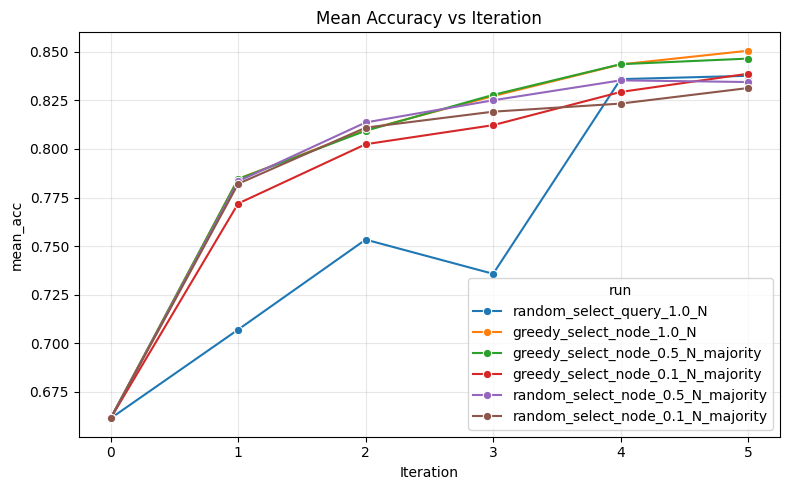

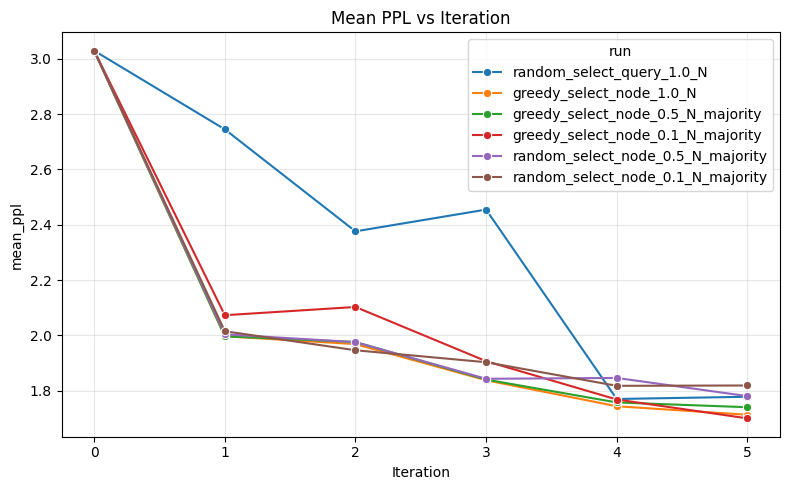

In [6]:
# query_list = ['333b', '355a', '330b', '334e', '331d', '334d', '327a', '330a', '334a', '331b']

# query_list = ['333b', '355a', '330b', '334e', '331b']
query_list = ['331d', '334d', '327a', '330a', '334a', '333b', '355a', '330b', '334e', '331b']

# random_select_query_10_N
path_tmpl = "/home/ruomeng/gae/results_new/results_group_random/24_group_random_node_select_entropy_percent1.0_T5_{query}.jsonl"
df_group_entropy = load_results(query_list, path_tmpl)
random_select_query_10_N = (df_group_entropy.groupby("iteration", as_index=False)[["mean_acc", "mean_ppl"]].mean(numeric_only=True).sort_values("iteration"))

# greedy_select_node_10_N
path_tmpl = "/home/ruomeng/gae/results_new/results_group_entropy/24_group_entropy_node_select_entropy_percent1.0_T5_['{query}']_majority.jsonl"
df_group_entropy = load_results(query_list, path_tmpl)
greedy_select_node_10_N = (df_group_entropy.groupby("iteration", as_index=False)[["mean_acc", "mean_ppl"]].mean(numeric_only=True).sort_values("iteration"))

# greedy_select_node_05_N_majority
path_tmpl = "/home/ruomeng/gae/results_new/results_group_entropy/24_group_entropy_node_select_entropy_percent0.5_T5_['{query}']_majority.jsonl"
df_group_entropy = load_results(query_list, path_tmpl)
greedy_select_node_05_N_majority = (df_group_entropy.groupby("iteration", as_index=False)[["mean_acc", "mean_ppl"]].mean(numeric_only=True).sort_values("iteration"))

# greedy_select_node_01_N_majority
path_tmpl = "/home/ruomeng/gae/results_new/results_group_entropy/24_group_entropy_node_select_entropy_percent0.1_T5_['{query}']_majority.jsonl"
df_group_entropy = load_results(query_list, path_tmpl)
greedy_select_node_01_N_majority = (df_group_entropy.groupby("iteration", as_index=False)[["mean_acc", "mean_ppl"]].mean(numeric_only=True).sort_values("iteration"))

# random_select_node_05_N_majority
path_tmpl = "/home/ruomeng/gae/results_new/results_group_entropy/24_group_entropy_node_select_random_percent0.5_T5_['{query}']_majority.jsonl"
df_group_entropy = load_results(query_list, path_tmpl)
random_select_node_05_N_majority = (df_group_entropy.groupby("iteration", as_index=False)[["mean_acc", "mean_ppl"]].mean(numeric_only=True).sort_values("iteration"))

# random_select_node_01_N_majority
path_tmpl = "/home/ruomeng/gae/results_new/results_group_entropy/24_group_entropy_node_select_random_percent0.1_T5_['{query}']_majority.jsonl"
df_group_entropy = load_results(query_list, path_tmpl)
random_select_node_01_N_majority = (df_group_entropy.groupby("iteration", as_index=False)[["mean_acc", "mean_ppl"]].mean(numeric_only=True).sort_values("iteration"))

# # greedy_select_node_05_N_prediction
# path_tmpl = "/home/ruomeng/gae/results_new/results_group_entropy/24_group_entropy_node_select_entropy_percent0.5_T5_['{query}']_prediction.jsonl"
# df_group_entropy = load_results(query_list, path_tmpl)
# greedy_select_node_05_N_prediction = (df_group_entropy.groupby("iteration", as_index=False)[["mean_acc", "mean_ppl"]].mean(numeric_only=True).sort_values("iteration"))

# # greedy_select_node_01_N_prediction
# path_tmpl = "/home/ruomeng/gae/results_new/results_group_entropy/24_group_entropy_node_select_entropy_percent0.1_T5_['{query}']_prediction.jsonl"
# df_group_entropy = load_results(query_list, path_tmpl)
# greedy_select_node_01_N_prediction = (df_group_entropy.groupby("iteration", as_index=False)[["mean_acc", "mean_ppl"]].mean(numeric_only=True).sort_values("iteration"))

# ---------------------------
# Example:

plot_per_iter_seaborn(
    {"random_select_query_1.0_N": random_select_query_10_N, 
     "greedy_select_node_1.0_N": greedy_select_node_10_N,
     "greedy_select_node_0.5_N_majority": greedy_select_node_05_N_majority,
     "greedy_select_node_0.1_N_majority": greedy_select_node_01_N_majority,
     "random_select_node_0.5_N_majority": random_select_node_05_N_majority,
     "random_select_node_0.1_N_majority": random_select_node_01_N_majority},
    metric="mean_acc", title="Mean Accuracy vs Iteration", rolling=None, markers=True
)

plot_per_iter_seaborn(
    {"random_select_query_1.0_N": random_select_query_10_N, 
     "greedy_select_node_1.0_N": greedy_select_node_10_N,
     "greedy_select_node_0.5_N_majority": greedy_select_node_05_N_majority,
     "greedy_select_node_0.1_N_majority": greedy_select_node_01_N_majority,
     "random_select_node_0.5_N_majority": random_select_node_05_N_majority,
     "random_select_node_0.1_N_majority": random_select_node_01_N_majority},
    metric="mean_ppl", title="Mean PPL vs Iteration", rolling=None, markers=True
)


60
60
60
60


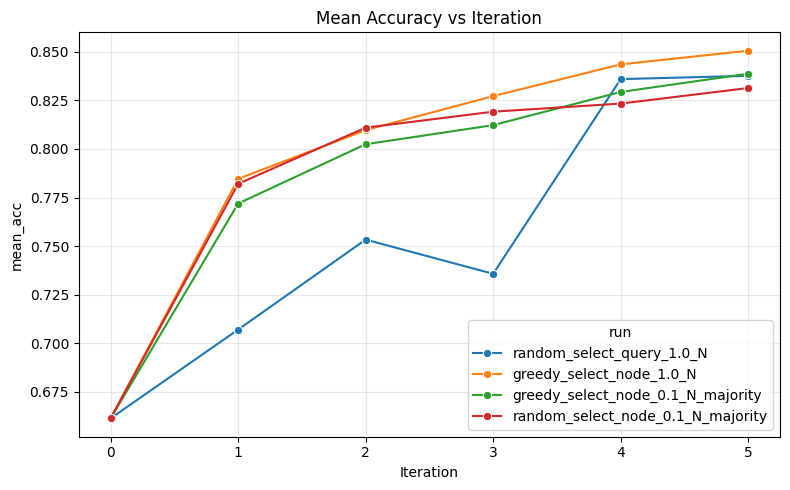

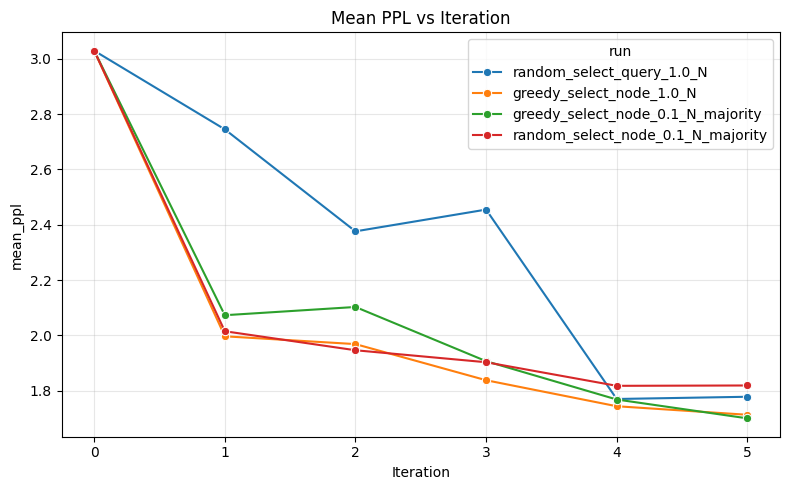

In [7]:
# query_list = ['333b', '355a', '330b', '334e', '331d', '334d', '327a', '330a', '334a', '331b']

# query_list = ['333b', '355a', '330b', '334e', '331b']
query_list = ['333b', '355a', '330b', '334e', '331d', '334d', '327a', '330a', '334a', '331b']

# random_select_query_10_N
path_tmpl = "/home/ruomeng/gae/results_new/results_group_random/24_group_random_node_select_entropy_percent1.0_T5_{query}.jsonl"
df_group_entropy = load_results(query_list, path_tmpl)
random_select_query_10_N = (df_group_entropy.groupby("iteration", as_index=False)[["mean_acc", "mean_ppl"]].mean(numeric_only=True).sort_values("iteration"))

# greedy_select_node_10_N
path_tmpl = "/home/ruomeng/gae/results_new/results_group_entropy/24_group_entropy_node_select_entropy_percent1.0_T5_['{query}']_majority.jsonl"
df_group_entropy = load_results(query_list, path_tmpl)
greedy_select_node_10_N = (df_group_entropy.groupby("iteration", as_index=False)[["mean_acc", "mean_ppl"]].mean(numeric_only=True).sort_values("iteration"))

# greedy_select_node_MIG_N_majority
# path_tmpl = "/home/ruomeng/gae/results_MIG/results_group_entropy/24_group_entropy_node_select_entropy_MIG_T5_['{query}']_majority.jsonl"
# df_group_entropy = load_results(query_list, path_tmpl)
# greedy_select_node_MIG_majority = (df_group_entropy.groupby("iteration", as_index=False)[["mean_acc", "mean_ppl"]].mean(numeric_only=True).sort_values("iteration"))

# greedy_select_node_01_N_majority
path_tmpl = "/home/ruomeng/gae/results_new/results_group_entropy/24_group_entropy_node_select_entropy_percent0.1_T5_['{query}']_majority.jsonl"
df_group_entropy = load_results(query_list, path_tmpl)
greedy_select_node_01_N_majority = (df_group_entropy.groupby("iteration", as_index=False)[["mean_acc", "mean_ppl"]].mean(numeric_only=True).sort_values("iteration"))

# random_select_node_01_N_majority
path_tmpl = "/home/ruomeng/gae/results_new/results_group_entropy/24_group_entropy_node_select_random_percent0.1_T5_['{query}']_majority.jsonl"
df_group_entropy = load_results(query_list, path_tmpl)
random_select_node_01_N_majority = (df_group_entropy.groupby("iteration", as_index=False)[["mean_acc", "mean_ppl"]].mean(numeric_only=True).sort_values("iteration"))

# # greedy_select_node_05_N_prediction
# path_tmpl = "/home/ruomeng/gae/results_new/results_group_entropy/24_group_entropy_node_select_entropy_percent0.5_T5_['{query}']_prediction.jsonl"
# df_group_entropy = load_results(query_list, path_tmpl)
# greedy_select_node_05_N_prediction = (df_group_entropy.groupby("iteration", as_index=False)[["mean_acc", "mean_ppl"]].mean(numeric_only=True).sort_values("iteration"))

# # greedy_select_node_01_N_prediction
# path_tmpl = "/home/ruomeng/gae/results_new/results_group_entropy/24_group_entropy_node_select_entropy_percent0.1_T5_['{query}']_prediction.jsonl"
# df_group_entropy = load_results(query_list, path_tmpl)
# greedy_select_node_01_N_prediction = (df_group_entropy.groupby("iteration", as_index=False)[["mean_acc", "mean_ppl"]].mean(numeric_only=True).sort_values("iteration"))

# ---------------------------
# Example:

plot_per_iter_seaborn(
    {"random_select_query_1.0_N": random_select_query_10_N, 
     "greedy_select_node_1.0_N": greedy_select_node_10_N,
     "greedy_select_node_0.1_N_majority": greedy_select_node_01_N_majority,
     "random_select_node_0.1_N_majority": random_select_node_01_N_majority,},
    metric="mean_acc", title="Mean Accuracy vs Iteration", rolling=None, markers=True
)

plot_per_iter_seaborn(
    {"random_select_query_1.0_N": random_select_query_10_N, 
     "greedy_select_node_1.0_N": greedy_select_node_10_N,
     "greedy_select_node_0.1_N_majority": greedy_select_node_01_N_majority,
     "random_select_node_0.1_N_majority": random_select_node_01_N_majority,},
    metric="mean_ppl", title="Mean PPL vs Iteration", rolling=None, markers=True
)


In [8]:
greedy_select_node_01_N_majority

,iteration,mean_acc,mean_ppl
0,0,0.661218,3.029279
1,1,0.771902,2.073079
2,2,0.802457,2.102872
3,3,0.812286,1.906975
4,4,0.829380,1.768350
5,5,0.838782,1.700261


In [9]:
random_select_node_01_N_majority

,iteration,mean_acc,mean_ppl
0,0,0.661218,3.029279
1,1,0.782051,2.015113
2,2,0.811004,1.946429
3,3,0.819231,1.903103
4,4,0.823397,1.817813
5,5,0.831410,1.819050
